https://towardsdatascience.com/how-to-generate-music-using-a-lstm-neural-network-in-keras-68786834d4c5

Using this tutorial to learn how to import midi files and convert to tensors.

In [1]:
import glob
from music21 import converter, instrument, note, chord, stream
import numpy as np
from tqdm import tqdm
import pickle

In [1]:

notes = []
durations = []

file = 'Midi_files/archive/DOS.mid'
for file in tqdm(glob.glob('Midi_files/Jazz_Midi/*.mid')):
    midi = converter.parse(file)

    parts = instrument.partitionByInstrument(midi)


    if parts:
        notes_to_parse = parts.parts[0].recurse()
    else:
        notes_to_parse = midi.flat.notes

    for element in notes_to_parse:

        if isinstance(element, note.Note):
            notes.append(str(element.pitch))
            durations.append(float(element.duration.quarterLength))

        elif isinstance(element, chord.Chord):
            notes.append(('.'.join(str(n) for n in element.normalOrder)))
            durations.append(float(element.duration.quarterLength))


    

100%|██████████| 943/943 [1:49:39<00:00,  6.98s/it]


In [2]:
# save note and duration data (it takes ages to process)
import pickle

def save_list(list_to_save, file_name):
    with open(file_name, 'wb') as fp:
        pickle.dump(list_to_save, fp)

def load_list(file_name):
    with open(file_name, 'rb') as fp:
        return pickle.load(fp)


In [ ]:
save_list(notes, 'saved_lists/notes.txt')
save_list(durations, 'saved_lists/durations.txt')

In [3]:
# Import notes and durations 

notes = load_list('saved_lists/notes.txt')
durations = load_list('saved_lists/durations.txt')

In [4]:
# Create input sequences for the network
sequence_length = 100
step = 1

# get all pitch names
pitchnames = sorted(set(item for item in notes))
dur_names = sorted(set(item for item in durations))

print('Number of individual notes: ', len(pitchnames))
print('Number of individual durations: ', len(dur_names))

# Create dictionary to convert notes to ints and vice versa
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
int_to_note = dict((number, note) for number, note in enumerate(pitchnames))

dur_to_int = dict((dur, number) for number, dur in enumerate(dur_names))
int_to_dur = dict((number, dur) for number, dur in enumerate(dur_names))

note_sentences = []
next_notes = []
dur_sentences = []
next_dur = []


#Create target and sentences window
for i in range(0, len(notes) - sequence_length, step):
    
    note_sentences.append(notes[i: i+sequence_length])
    next_notes.append(notes[i+sequence_length])

    dur_sentences.append(durations[i: i+sequence_length])
    next_dur.append(durations[i+sequence_length])

note_sentences = np.array(note_sentences)
next_notes = np.array(next_notes)

dur_sentences = np.array(dur_sentences)
next_dur = np.array(next_dur)

# print('Sentence Window:')
# print(sentences[:5])
# print('Target charaters')
# print (next_notes[:5])
print('Number of note sequences:', len(note_sentences))
print('Number of dur sequences:', len(dur_sentences))



Number of individual notes:  787
Number of individual durations:  189
Number of note sequences: 498456
Number of dur sequences: 498456


In [6]:
# Transfer notes to index


def get_data(sentences, next_notes, dict):
    x = np.zeros((len(sentences),sequence_length))
    y = np.zeros(len(sentences))

    length = len(sentences)
    index = 0

    for i in range(length):
        sentence = sentences[i]
        for t, char in enumerate(sentence):
            x[i, t] = dict[char]
        
        y[i] = dict[next_notes[i]]

    return x, y

note_train_x, note_train_y = get_data(note_sentences, next_notes, note_to_int)
dur_train_x, dur_train_y = get_data(dur_sentences, next_dur, dur_to_int)

print('Shape of training_x:', note_train_x.shape)
print('Shape of training_y:', note_train_y.shape)

print('Shape of training_x:', dur_train_x.shape)
print('Shape of training_y:', dur_train_y.shape)

KeyboardInterrupt: 

In [14]:
# Save training data
save_list(note_train_x, 'saved_lists/note_train_x.txt')
save_list(note_train_y, 'saved_lists/note_train_y.txt')

save_list(dur_train_x, 'saved_lists/dur_train_x.txt')
save_list(dur_train_y, 'saved_lists/dur_train_y.txt')

In [5]:
# Load training data
import pickle

note_train_x = load_list('saved_lists/note_train_x.txt')
note_train_y = load_list('saved_lists/note_train_y.txt')

dur_train_x = load_list('saved_lists/dur_train_x.txt')
dur_train_y = load_list('saved_lists/dur_train_y.txt')

In [6]:
# Building the model

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt

class Simple_LSTM(nn.Module):
    def __init__(self, n_vocab, hidden_dim, embedding_dim, dropout=0.2):
        super(Simple_LSTM, self).__init__()

        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, dropout = dropout, num_layers=2)
        self.embeddings = nn.Embedding(n_vocab, embedding_dim)
        self.fc = nn.Linear(hidden_dim, n_vocab)
    def forward(self, seq_in):
        #input should be (Sequnce_length,batchsize,hidden_layer), so we need to transpose the input
        embedded = self.embeddings(seq_in.t())
        lstm_out, _ = self.lstm(embedded)

        ht = lstm_out[-1]
        out = self.fc(ht)
        return out

In [7]:
# Create DataLoader for mini-batch training
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

note_x_train_tensor = torch.tensor(note_train_x, dtype=torch.long).to(device)
note_y_train_tensor = torch.tensor(note_train_y, dtype=torch.long).to(device)

dur_x_train_tensor = torch.tensor(dur_train_x, dtype=torch.long).to(device)
dur_y_train_tensor = torch.tensor(dur_train_y, dtype=torch.long).to(device)

from torch.utils.data import Dataset, DataLoader
note_train = torch.utils.data.TensorDataset(note_x_train_tensor, note_y_train_tensor)
note_train_loader = torch.utils.data.DataLoader(note_train, batch_size = 128)

dur_train = torch.utils.data.TensorDataset(dur_x_train_tensor, dur_y_train_tensor)
dur_train_loader = torch.utils.data.DataLoader(dur_train, batch_size = 128)

cuda


In [8]:
#Training the network
def train_net(n_epoch, loss_fn, optimizer, model, train_loader, device):

    losses = []
    eval_losses = []
    running_loss = 0
    eval_running_loss = 0

    #loop through n_epoch times
    for epoch in range(n_epoch):

        for i, data in enumerate(train_loader, 0):

            inputs, labels = data[0].to(device), data[1].to(device)

            # Set model to train mode
            model.train()
            #Make predictions
            pred = model(inputs)
            
            # Compute loss
            loss = loss_fn(pred, labels)
            # Compute gradients
            loss.backward()
            # Update params and zero grads
            optimizer.step()
            optimizer.zero_grad()
            
            # print statistics
            running_loss += loss.item()
            if i % len(train_loader) == len(train_loader)-1:    # print every len(train_loader) mini-batches
                print('[%d, %5d] loss: %.5f' %(epoch + 1, i + 1, running_loss / len(train_loader)))
                losses.append(running_loss/len(train_loader)) 
                running_loss = 0.0
        if epoch%10 == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': losses[epoch-1],
                }, 'model_checkpoint.pth')

    plt.subplot(1,2,1)
    plt.plot(losses, label='Training loss')

    print('Finished Training')
    
    torch.save(model.state_dict(), PATH)

    print('Saved the Model!')

cuda
[1,  3895] loss: 1.37399
[2,  3895] loss: 1.25310
[3,  3895] loss: 1.22051
[4,  3895] loss: 1.20381
[5,  3895] loss: 1.19139
[6,  3895] loss: 1.17380
[7,  3895] loss: 1.16399
[8,  3895] loss: 1.15241
[9,  3895] loss: 1.14474
[10,  3895] loss: 1.13574
[11,  3895] loss: 1.12687
[12,  3895] loss: 1.11812
[13,  3895] loss: 1.10909
[14,  3895] loss: 1.10075
[15,  3895] loss: 1.09173
[16,  3895] loss: 1.08522
[17,  3895] loss: 1.07756
[18,  3895] loss: 1.07004
[19,  3895] loss: 1.06336
[20,  3895] loss: 1.05457
[21,  3895] loss: 1.04541
[22,  3895] loss: 1.04127
[23,  3895] loss: 1.03372
[24,  3895] loss: 1.02945
[25,  3895] loss: 1.02023
[26,  3895] loss: 1.01289
[27,  3895] loss: 1.00676
[28,  3895] loss: 1.00078
[29,  3895] loss: 0.99437
[30,  3895] loss: 0.98863
[31,  3895] loss: 0.98429
[32,  3895] loss: 0.97858
[33,  3895] loss: 0.97201
[34,  3895] loss: 0.96985
[35,  3895] loss: 0.96306
[36,  3895] loss: 0.95867
[37,  3895] loss: 0.95332
[38,  3895] loss: 0.94789
[39,  3895] loss

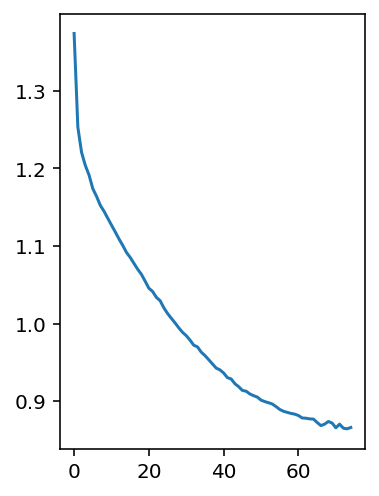

In [12]:
# Training
print(device)

# note_model = Simple_LSTM(len(pitchnames), 256, 256).to(device)
# note_optimizer = torch.optim.Adam(note_model.parameters(), lr = 0.002)
loss_fn = torch.nn.CrossEntropyLoss()

# n_epochs = 75
# PATH = 'jazz_midi_notes.pth'
# train_net(n_epochs, loss_fn, note_optimizer, note_model, note_train_loader, device)

n_epochs = 75
PATH = 'jazz_midi_dur.pth'
dur_model = Simple_LSTM(len(dur_names), 256, 256).to(device)
dur_optimizer = torch.optim.Adam(dur_model.parameters(), lr = 0.002)
train_net(n_epochs, loss_fn, dur_optimizer, dur_model, dur_train_loader, device)


#model.load_state_dict(torch.load(PATH))

In [13]:
# Function to choose next char for generated lyrics
# We want some randomness so that the same char is not always picked

def sample(preds, temperature):
    
    preds = np.asarray(preds).astype('float64')
    
    # Adds a lil bit of randomness
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)

    probas = np.random.multinomial(1, preds, 1)

    return np.argmax(probas)

In [29]:
start = note_train_x[np.random.randint(0,sequence_length)]

In [15]:
# Generate some notes

variance = 0.5

def generate_seq(path, start, variance, model):

    generated = []
    original = start
    window = start
    model.load_state_dict(torch.load(path))

    for i in tqdm(range(200)):

        x = np.zeros((1, sequence_length))
        
        for t, note_ in enumerate(window):
            #change input to vec of ints
            # loop through current window and encode it to the vector x
            x[0, t] = note_

        # send x to the gpu to be fed into net
        x_in = Variable(torch.LongTensor(x).to(device))
        pred = model(x_in)
        
        # retrieve data from gpu and apply softmax
        pred = np.array(F.softmax(pred, dim=1).data[0].cpu())
        
        #sample func adds a little but of randomness and returns the next char as int
        next_index = sample(pred, variance)

        #add new char to generated lyrics
        generated.append(next_index)
        
        #shift window along to include new char and leave first char
        window = np.append(window, next_index)
        window = window[1:]

    print(original)
    print(generated)

    return generated

    

In [29]:

# Create notes and chords from output of net

note_model = Simple_LSTM(len(pitchnames), 256, 256).to(device)
gen_notes = generate_seq('jazz_midi_notes.pth', note_train_x[np.random.randint(0,sequence_length)], 0.2, note_model)

dur_model = Simple_LSTM(len(dur_names), 256, 256).to(device)
gen_dur = generate_seq('jazz_midi_dur.pth', dur_train_x[np.random.randint(0,sequence_length)], 0.9, dur_model)

def get_midi(notes_generated, dur_generated, midi_name):

    offset = 0
    output_notes = []

    for i in range(len(notes_generated)):

        note_to_encode = int_to_note[notes_generated[i]]

        duration = int_to_dur[dur_generated[i]]

        # if chord
        if('.' in note_to_encode) or note_to_encode.isdigit():

            notes_in_chord = note_to_encode.split('.')
            notes = []

            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)

            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            new_chord.quarterLength = duration
            output_notes.append(new_chord)

        # if note
        else:
            new_note = note.Note(note_to_encode)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            new_note.quarterLength = duration
            output_notes.append(new_note)

        offset += 0.5 # so notes dont stack

    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp=midi_name)

get_midi(gen_notes, gen_dur, 'jazz_midi.mid')


 11%|█         | 11/100 [00:00<00:00, 101.50it/s]/tmp/ipykernel_2972/2180127388.py:9: RuntimeWarning: divide by zero encountered in log
  preds = np.log(preds) / temperature
100%|██████████| 100/100 [00:00<00:00, 102.71it/s]


[755. 361. 745. 743. 529. 599. 745. 529. 745. 513. 745. 410. 743. 699.
 744. 773. 729. 519. 217. 743. 783. 700. 745. 482. 745. 700. 659. 686.
 685. 783. 743. 745. 685. 412. 745. 743. 699. 699. 744. 700. 745. 745.
 720. 639. 745. 416. 710. 398. 745. 416. 684. 701. 639. 686. 380. 745.
 639. 745. 743. 410. 699. 700. 710. 410. 700. 255. 236. 710. 410. 700.
 699. 410. 729. 231. 755. 361. 700. 699. 361. 753. 783. 231. 745. 540.
 755. 361. 745. 412. 743. 772. 684. 699. 684. 684. 699. 709. 744. 743.
 609. 351.]
[699, 700, 720, 700, 744, 684, 684, 684, 684, 684, 684, 684, 700, 744, 684, 700, 744, 684, 684, 684, 700, 700, 684, 684, 744, 744, 684, 684, 684, 684, 684, 684, 684, 684, 684, 684, 684, 684, 684, 684, 684, 684, 684, 684, 684, 684, 684, 684, 684, 684, 684, 684, 684, 684, 699, 684, 684, 684, 684, 585, 684, 684, 684, 684, 684, 684, 684, 684, 684, 684, 684, 700, 710, 729, 710, 700, 729, 729, 729, 710, 700, 700, 729, 745, 729, 700, 700, 729, 729, 700, 729, 700, 729, 745, 700, 700, 729, 700, 

100%|██████████| 100/100 [00:00<00:00, 115.16it/s]

[ 4.  2.  4.  6.  4. 14.  6.  3.  4.  2.  4.  2.  2.  2.  4.  2.  8.  6.
  3.  2.  2.  4.  6.  2.  2.  4.  8.  2.  4.  6.  2.  2.  4.  6.  2. 14.
  4.  4.  4.  2.  4.  2.  4.  2.  4.  2.  2.  4.  4.  2.  4.  2.  2.  6.
  4.  2.  4.  4.  4.  2.  2.  4.  6.  2.  8.  6.  1.  6.  6.  6.  6.  6.
  6.  5.  7.  7.  6.  3.  2. 11.  1.  4.  6.  4.  2.  4.  8.  2.  4.  6.
  4.  6.  4.  2.  2.  3.  3. 36.  6. 24.]
[3, 36, 3, 3, 3, 36, 3, 3, 3, 9, 36, 3, 3, 3, 3, 3, 27, 8, 3, 36, 3, 3, 36, 3, 3, 3, 2, 3, 2, 1, 1, 3, 36, 3, 3, 3, 3, 18, 36, 3, 3, 3, 3, 18, 1, 3, 12, 3, 3, 27, 12, 3, 3, 27, 9, 3, 3, 3, 3, 3, 33, 36, 3, 3, 3, 9, 3, 9, 3, 3, 3, 27, 3, 3, 27, 36, 3, 3, 3, 3, 9, 36, 3, 3, 18, 3, 3, 3, 3, 3, 3, 18, 3, 6, 3, 3, 3, 15, 3, 3]
